# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow.keras.utils as utils

import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from usda import UsdaClient

**Declare parameters**

In [2]:
ROOT_DIR = os.path.dirname(os.getcwd())

IMAGE_SIZE = 512

API_KEY = "4INghUtThsIBWPTIcvfKyf0kNS6MtSXcC4R6mpNB"

**Enable GPU**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

**Fetch class names**

In [5]:
FOOD256_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food256")

class_names = []

with open(os.path.join(FOOD256_DIR, "condensed-category.txt")) as file:
    file.readline()
    for line in file.readlines():
        class_names.append(line.split('\t')[1].strip())
                           
class_names

['rice',
 "chicken-'n'-egg on rice",
 'beef curry',
 'sushi',
 'chicken rice',
 'fried rice',
 'toast',
 'croissant',
 'roll bread',
 'raisin bread',
 'hamburger',
 'pizza',
 'sandwiches',
 'spaghetti',
 'vegetable tempura',
 'sausage',
 'omelet',
 'stew',
 'fried fish',
 'grilled salmon',
 'sweet and sour pork',
 'tempura',
 'fried chicken',
 'steak',
 'egg sunny-side up',
 'roast chicken',
 'fried shrimp',
 'potato salad',
 'green salad',
 'pizza toast',
 'hot dog',
 'french fries',
 'mixed rice',
 'green curry',
 'paella',
 'pancake',
 'crape',
 'tiramisu',
 'waffle',
 'shortcake',
 'mushroom risotto',
 'french toast',
 'minestrone',
 'chicken nugget',
 'french bread',
 'bagel',
 'scone',
 'tortilla',
 'tacos',
 'nachos',
 'meat loaf',
 'scrambled egg',
 'lasagna',
 'Caesar salad',
 'oatmeal',
 'muffin',
 'popcorn',
 'doughnut',
 'apple pie',
 'lamb kebabs',
 'roast duck',
 'hot pot',
 'pork belly',
 'custard tart',
 'stir-fried mixed vegetables',
 'Pork with lemon',
 'Deep Fried Ch

**Fetch model architecture**

In [6]:
print("Fetching model architecture... ", end="")

backbone = torchvision.models.mobilenet_v2(pretrained=False).features
backbone.out_channels = 1280

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=len(class_names), rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model = model.to(device)

print("done")

Fetching model architecture... done


**Load model weights**

In [8]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "condensed_food_detection", "mobilenet_backbone.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Predict

**Load image from url**

65536/59436 [=================================] - 0s 2us/step


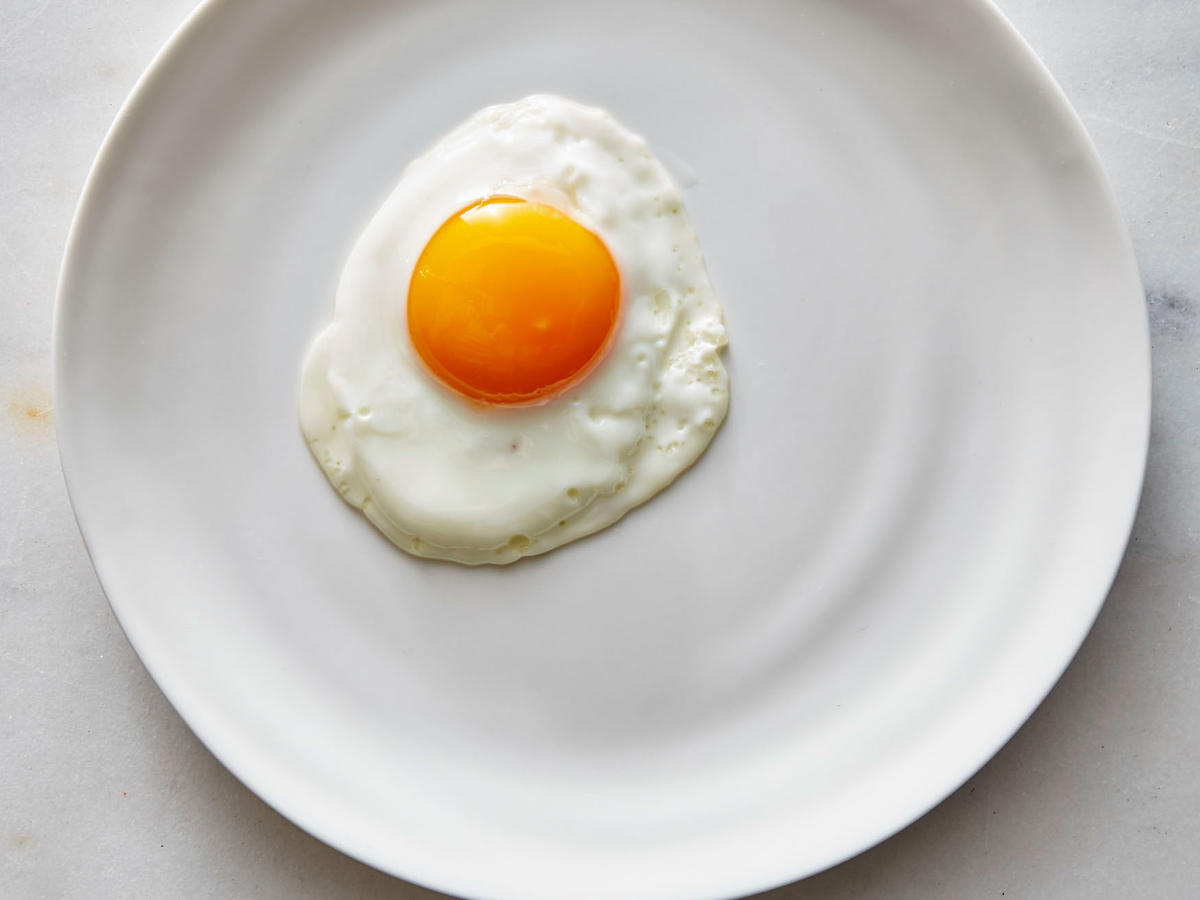

In [18]:
def loadImage(url):
    filename = url.split('/')[-1]
    img = utils.get_file(filename, url)
    img = Image.open(img)
    return img

img = loadImage("https://img1.cookinglight.timeinc.net/sites/default/files/styles/medium_2x/public/image/2017/01/main/pristine-sunny-side-up-eggs.jpg")
img

**Format image for model input**

In [19]:
# custom transform for R-CNN input
class CustomTransform:
    def __init__(self, image_size):
        self.image_size = image_size
        
    def __call__(self, img):
        # resize to a max of IMAGE_SIZE
        w, h = img.size
        scale = min(IMAGE_SIZE/w, IMAGE_SIZE/h)
        img = transforms.functional.resize(img, (int(h*scale), int(w*scale)))
        
        # add padding to a size of IMAGE_SIZE
        img = transforms.functional.pad(img, (0, 0, IMAGE_SIZE-int(w*scale), IMAGE_SIZE-int(h*scale)))
        
        # convert to tensor
        img = transforms.functional.to_tensor(img)

        # normalize
        img = img / 255
        return img

transform = CustomTransform(image_size=IMAGE_SIZE)

img = transform(img)
images = img.unsqueeze(0)

**Apply model on image**

In [20]:
def predict(images):
    images = images.to(device)
    model.eval()
    
    with torch.no_grad():
        outputs = model(images)
    
    return outputs

results = predict(images)

**Draw predicted bounding boxes on image**

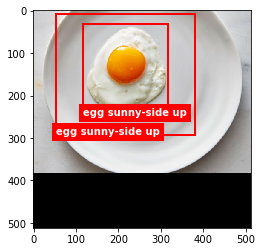

In [27]:
CONFIDENCE_THRESHOLD = 0.8

def drawResults(img, target):
    fig, axis= plt.subplots(1)

    img = np.transpose(img, (1,2,0))
    img = img * 255
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # draw results
    for i in range(len(target["labels"])):
        if(target["scores"][i] < CONFIDENCE_THRESHOLD):
            break
        
        # draw bounding box
        x1, y1, x2, y2 = target["boxes"][i]
        box = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        axis.add_patch(box)
        axis.text(x1, y2, class_names[target["labels"][i]], fontdict=dict(color='w', weight='bold'), bbox=dict(facecolor='r', edgecolor='none'))
        foods.append(class_names[target["labels"][i]])
        
    plt.show()

foods = []
drawResults(img, results[0])

# Nutritional lookup

**Search USDA for foods with predicted class**

In [117]:
client = UsdaClient(API_KEY)

nutrients = {}

for food_item in foods:
    # seach USDA with predicted image class as search term
    food_results = client.search_foods(food_item, 1)

    food = next(food_results)

    # fetch food report for top result
    food_report = client.get_food_report(food.id)
    
    # add nutritional information to dictionary
    for nutrient in food_report.nutrients:
        key = "{0} ({1})".format(nutrient.name, nutrient.unit)
        nutrients[key] = nutrients.get(key, 0) + nutrient.value
    
nutrients

{'Water (g)': 44.53,
 'Energy (kcal)': 393.0,
 'Protein (g)': 15.27,
 'Total lipid (fat) (g)': 12.44,
 'Carbohydrate, by difference (g)': 53.81,
 'Fiber, total dietary (g)': 3.7,
 'Sugars, total (g)': 6.03,
 'Calcium, Ca (mg)': 127.0,
 'Iron, Fe (mg)': 3.29,
 'Magnesium, Mg (mg)': 21.0,
 'Phosphorus, P (mg)': 107.0,
 'Potassium, K (mg)': 192.0,
 'Sodium, Na (mg)': 670.0,
 'Zinc, Zn (mg)': 1.95,
 'Vitamin C, total ascorbic acid (mg)': 3.4,
 'Thiamin (mg)': 0.247,
 'Riboflavin (mg)': 0.239,
 'Niacin (mg)': 4.544,
 'Vitamin B-12 (µg)': 0.83,
 'Vitamin A, IU (IU)': 55.0,
 'Fatty acids, total saturated (g)': 3.504,
 'Fatty acids, total monounsaturated (g)': 3.768,
 'Fatty acids, total polyunsaturated (g)': 1.42,
 'Fatty acids, total trans (g)': 0.428,
 'Cholesterol (mg)': 27.0}